<a href="https://colab.research.google.com/github/OptimoCX/BootCampIA/blob/main/facedetection_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#""" Defining the libraries """
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

# Configuración de Generadores de Datos para el Entrenamiento del Modelo de Reconocimiento de Emociones

In [ ]:
# Ruta al directorio que contiene las imágenes organizadas en carpetas por clase
emotions_dir = '../input/deeplearning/augmented/all_data/'

# Tamaño del lote, es decir, cuántas imágenes se procesan a la vez
batch_size = 32

# Tamaño al que se redimensionarán todas las imágenes cargadas
image_size = (224, 224)

# Generador de datos con normalización de imágenes y división entrenamiento/validación
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normaliza los píxeles (0-255 a 0-1)
    validation_split=0.2         # Reserva el 20% de los datos para validación
)

# Generador de imágenes para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    emotions_dir,                # Ruta al conjunto de datos
    target_size=image_size,      # Redimensiona las imágenes a 224x224
    batch_size=batch_size,       # Número de imágenes por lote
    class_mode='categorical',    # Las etiquetas serán codificadas como one-hot
    shuffle=True,                # Mezcla aleatoriamente las imágenes en cada época
    subset='training'            # Utiliza el 80% de datos para entrenamiento
)

# Generador de imágenes para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    emotions_dir,                # Misma ruta de datos
    target_size=image_size,      # Redimensiona las imágenes a 224x224
    batch_size=batch_size,       # Número de imágenes por lote
    class_mode='categorical',    # Las etiquetas serán codificadas como one-hot
    shuffle=True,                # Mezcla las imágenes aleatoriamente
    subset='validation'          # Utiliza el 20% de datos para validación
)


Found 28475 images belonging to 6 classes.
Found 7115 images belonging to 6 classes.


# Visualizar el set de Entrenamiento

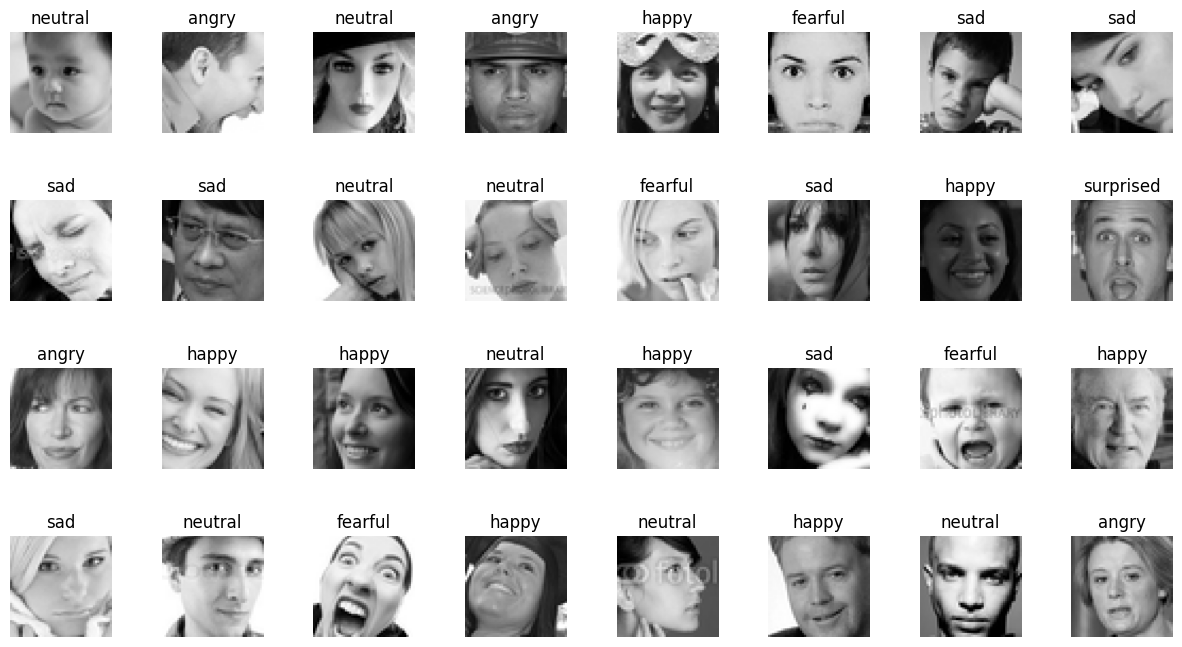

In [ ]:
# Obtiene el siguiente lote de imágenes (x_batch) y etiquetas (y_batch) del generador de entrenamiento
x_batch, y_batch = next(train_generator)

# Obtiene la lista de nombres de las clases (emociones) desde el generador
emotions = list(train_generator.class_indices.keys())

# Crea una figura con una grilla de 4 filas y 8 columnas para mostrar imágenes
fig, axes = plt.subplots(4, 8, figsize=(15, 8))

# Aplana el arreglo de ejes para poder iterar sobre ellos fácilmente
axes = axes.ravel()

# Itera sobre las primeras 32 imágenes del lote (4x8 = 32)
for i in np.arange(0, 4*8):
    axes[i].imshow(x_batch[i])  # Muestra la imagen en el eje correspondiente
    axes[i].axis('off')         # Oculta los ejes
    emotion_idx = np.argmax(y_batch[i])  # Obtiene el índice de la emoción (posición del 1 en el vector one-hot)
    axes[i].set_title(emotions[emotion_idx])  # Establece el nombre de la emoción como título de la imagen

# Ajusta el espacio entre imágenes para que no se sobrepongan
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Muestra la figura con las imágenes
plt.show()


# Dividir el set de datos entre entrenamiento y validación

In [ ]:
# Calcula el número total de clases (emociones) en el conjunto de datos
num_classes = len(emotions)

# Muestra el número de clases
num_classes


6

In [ ]:
# Divide manualmente el primer lote de imágenes y etiquetas en conjuntos de entrenamiento y validación
train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_generator[0][0],     # Imágenes del primer lote del generador
    train_generator[0][1],     # Etiquetas correspondientes del primer lote
    test_size=0.2,             # El 20% de los datos se usarán para validación
    random_state=13            # Semilla fija para que la división sea reproducible
)


# Preparando las Imagenes y los label para el entrenamiento de la Red Neuronal

In [ ]:
# Convierte las imágenes de entrenamiento a tipo float32 (formato estándar para redes neuronales)
train_images = train_images.astype('float32')

# Convierte las imágenes de validación a tipo float32
validation_images = validation_images.astype('float32')

# Convierte las etiquetas de entrenamiento en codificación one-hot (por ejemplo, [0, 1, 0])
train_labels = to_categorical(train_labels, num_classes)

# Convierte las etiquetas de validación en codificación one-hot
validation_labels = to_categorical(validation_labels, num_classes)


In [ ]:
# Muestra la forma (dimensiones) del conjunto de imágenes de entrenamiento
print(f"Training Images Shape: {train_images.shape}")

# Muestra la forma del conjunto de etiquetas de entrenamiento
print(f"Training Labels Shape: {train_labels.shape}")

# Muestra la forma del conjunto de imágenes de validación
print(f"Validation Images Shape: {validation_images.shape}")

# Muestra la forma del conjunto de etiquetas de validación
print(f"Validation Labels Shape: {validation_labels.shape}")


Training Images Shape: (25, 224, 224, 3)
Training Labels Shape: (25, 6, 6)
Validation Images Shape: (7, 224, 224, 3)
Validation Labels Shape: (7, 6, 6)


# Modelo 1 - Transfer Learning con Arquitectura VGG16

In [ ]:
# Inicializa el modelo VGG16 preentrenado con pesos de ImageNet, excluyendo las capas de clasificación final
vgg16 = VGG16(
    input_shape=(224, 224, 3),  # Tamaño de entrada esperado: imágenes de 224x224 píxeles con 3 canales (RGB)
    weights='imagenet',         # Carga los pesos preentrenados en el dataset ImageNet
    include_top=False           # Excluye la parte final del modelo (las capas densas de clasificación)
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Congela todas las capas del modelo VGG16 para evitar que sus pesos se actualicen durante el entrenamiento
for layer in vgg16.layers:
    layer.trainable = False  # Establece la propiedad 'trainable' en False para cada capa


In [ ]:
# Número de clases en el problema de clasificación (por ejemplo, 6 emociones)
num_classes = 6

# Aplana la salida del modelo VGG16 (conv layers) en un vector unidimensional
x = Flatten()(vgg16.output)

# Añade una capa densa totalmente conectada con 1024 neuronas y función de activación ReLU
x = Dense(1024, activation='relu')(x)

# Capa de salida con tantas neuronas como clases y activación softmax (para clasificación multiclase)
x = Dense(num_classes, activation='softmax')(x)


In [ ]:
# Construye un nuevo modelo combinando la entrada original de VGG16 con las capas personalizadas agregadas
model_1 = Model(vgg16.input, x)


In [ ]:
# Configura el optimizador Adam con una tasa de aprendizaje de 0.0001 (1e-4)
optimizer = Adam(learning_rate=1e-4)

# Compila el modelo para clasificación multiclase usando entropía cruzada categórica como función de pérdida
model_1.compile(
    loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase (etiquetas one-hot)
    optimizer=optimizer,              # Optimizador Adam previamente configurado
    metrics=['accuracy']              # Métrica de evaluación: precisión
)

# Muestra un resumen del modelo, incluyendo capas, parámetros y forma de entrada/salida
model_1.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,411,974 (154.16 MB)

 Trainable params: 25,697,286 (98.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Entrena el modelo usando los datos del generador de entrenamiento y validación
history_1 = model_1.fit(
    train_generator,              # Generador que proporciona los lotes de imágenes y etiquetas para entrenamiento
    epochs=10,                    # Número de épocas (iteraciones completas sobre el conjunto de entrenamiento)
    validation_data=validation_generator  # Generador para validar el rendimiento del modelo después de cada época
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/890 ━━━━━━━━━━━━━━━━━━━━ 8:01:39 33s/step - accuracy: 0.2812 - loss: 2.0401

I0000 00:00:1753233246.057089     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1753233246.073909     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


595/890 ━━━━━━━━━━━━━━━━━━━━ 56s 191ms/step - accuracy: 0.3947 - loss: 1.5476

W0000 00:00:1753233359.718787     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4147 - loss: 1.5002

W0000 00:00:1753233402.619432     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 234s 227ms/step - accuracy: 0.4148 - loss: 1.5000 - val_accuracy: 0.4665 - val_loss: 1.3714
Epoch 2/10


W0000 00:00:1753233448.033901     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 175ms/step - accuracy: 0.5513 - loss: 1.1860 - val_accuracy: 0.5085 - val_loss: 1.2966
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.5895 - loss: 1.0781 - val_accuracy: 0.5213 - val_loss: 1.2706
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.6243 - loss: 1.0092 - val_accuracy: 0.5376 - val_loss: 1.2150
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.6608 - loss: 0.9170 - val_accuracy: 0.5386 - val_loss: 1.2056
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.6772 - loss: 0.8792 - val_accuracy: 0.5175 - val_loss: 1.2885
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.6955 - loss: 0.8218 - val_accuracy: 0.5244 - val_loss: 1.2834
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.7273 - loss: 0.7517 - val_accuracy: 0.5219 - val_loss: 1.3206
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 157s 176ms/step - accuracy: 0.7571 - loss: 0.69

# Modelo 2: Transfer Learning con Arquitectura VGG16 - Fine Tuning: Congelando Capas

In [ ]:
# Inicializa una segunda instancia del modelo VGG16 preentrenado para usarla como extractor de características
base_model_2 = VGG16(
    input_shape=(224, 224, 3),  # Dimensiones de entrada esperadas por VGG16 (ancho, alto, canales)
    weights='imagenet',         # Carga pesos preentrenados obtenidos del dataset ImageNet
    include_top=False           # Excluye las capas densas finales del modelo original (usadas para clasificación)
)


In [ ]:
# Congela todas las capas del modelo base excepto las últimas 10,
# de modo que solo esas capas podrán ajustar sus pesos durante el entrenamiento
for layer in base_model_2.layers[:-10]:
    layer.trainable = False


In [ ]:
# Se agregan capas personalizadas al modelo base:
# Flatten convierte las salidas convolucionales en un vector 1D,
# Dense(1024) añade una capa completamente conectada con activación ReLU,
# y Dense(num_classes) genera la salida con activación softmax para clasificar en múltiples clases
x = Flatten()(base_model_2.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)


In [ ]:
# Se crea un nuevo modelo combinando la base VGG16 modificada con las capas personalizadas
model_2 = Model(inputs=base_model_2.input, outputs=x)


In [ ]:
# Se compila el modelo utilizando el optimizador Adam y la función de pérdida categórica
optimizer = Adam(learning_rate=1e-4)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Se muestra un resumen de la arquitectura del modelo
model_2.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,411,974 (154.16 MB)

 Trainable params: 39,266,566 (149.79 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
# Entrenamiento del modelo durante 10 épocas utilizando los datos de entrenamiento y validación
history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)


Epoch 1/10


W0000 00:00:1753235003.377815     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


298/890 ━━━━━━━━━━━━━━━━━━━━ 2:15 230ms/step - accuracy: 0.2413 - loss: 1.7812

W0000 00:00:1753235087.967115     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3295 - loss: 1.6130

W0000 00:00:1753235225.672809     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 274s 284ms/step - accuracy: 0.3296 - loss: 1.6128 - val_accuracy: 0.5077 - val_loss: 1.2764
Epoch 2/10


W0000 00:00:1753235256.242811     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 266ms/step - accuracy: 0.5565 - loss: 1.1287 - val_accuracy: 0.5746 - val_loss: 1.0993
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 265ms/step - accuracy: 0.6209 - loss: 0.9815 - val_accuracy: 0.5834 - val_loss: 1.0745
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 236s 265ms/step - accuracy: 0.6732 - loss: 0.8545 - val_accuracy: 0.6051 - val_loss: 1.0444
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 236s 265ms/step - accuracy: 0.7216 - loss: 0.7395 - val_accuracy: 0.6221 - val_loss: 1.0614
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 266ms/step - accuracy: 0.7760 - loss: 0.5995 - val_accuracy: 0.6277 - val_loss: 1.0782
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 266ms/step - accuracy: 0.8354 - loss: 0.4490 - val_accuracy: 0.6242 - val_loss: 1.1497
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 266ms/step - accuracy: 0.8940 - loss: 0.3005 - val_accuracy: 0.6249 - val_loss: 1.4159
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 237s 266ms/step - accuracy: 0.9245 - loss: 0.21

# Modelo 3: Transfer Learning con Arquitectura VGG16  - Fine Tuning: Congelamiento de Capas / Se incluye Dropout para Regularización

In [ ]:
# Inicialización de un tercer modelo VGG16 para extracción de características con pesos preentrenados en ImageNet, excluyendo las capas superiores (top layers)
vgg16_3 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)


In [ ]:
# Configurar todas las capas del tercer modelo VGG16 como no entrenables, excepto las últimas cuatro
for layer in vgg16_3.layers[:-4]:
    layer.trainable = False


In [ ]:
# Añadir capas personalizadas al tercer modelo VGG16, incluyendo Dropout para regularización
num_classes = 6
x = Flatten()(vgg16_3.output)                        # Aplanar la salida del modelo base
x = Dense(1024, activation='relu')(x)                # Capa densa con 1024 neuronas y activación ReLU
x = Dropout(0.2)(x)                                  # Dropout para prevenir sobreajuste (20%)
x = Dense(512, activation='relu')(x)                 # Otra capa densa con 512 neuronas
x = Dropout(0.2)(x)                                  # Segundo Dropout con 20%
x = Dense(num_classes, activation='softmax')(x)      # Capa de salida con activación softmax para clasificación en 6 clases


In [ ]:
# Crear un nuevo modelo combinando la base VGG16 adaptada con las capas personalizadas de clasificación
model_3 = Model(inputs=vgg16_3.input, outputs=x)


In [ ]:
# Compilar el modelo con la función de pérdida de entropía cruzada categórica, el optimizador Adam y la métrica de precisión
optimizer = Adam(learning_rate=1e-4)
model_3.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model_3.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         3,07

 Total params: 40,933,702 (156.15 MB)

 Trainable params: 33,298,438 (127.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Train the model
history_3 = model_3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
  1/890 ━━━━━━━━━━━━━━━━━━━━ 1:26:18 6s/step - accuracy: 0.2500 - loss: 2.1048

W0000 00:00:1753237758.497591     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


838/890 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.4152 - loss: 1.4600

W0000 00:00:1753237899.829719     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4198 - loss: 1.4502

W0000 00:00:1753237909.412973     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 188s 204ms/step - accuracy: 0.4199 - loss: 1.4501 - val_accuracy: 0.5435 - val_loss: 1.1569
Epoch 2/10


W0000 00:00:1753237940.349231     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.5901 - loss: 1.0655 - val_accuracy: 0.5824 - val_loss: 1.0645
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 196ms/step - accuracy: 0.6533 - loss: 0.9081 - val_accuracy: 0.5987 - val_loss: 1.0543
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.7115 - loss: 0.7695 - val_accuracy: 0.6176 - val_loss: 1.0544
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.7659 - loss: 0.6252 - val_accuracy: 0.6256 - val_loss: 1.0964
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.8304 - loss: 0.4714 - val_accuracy: 0.6256 - val_loss: 1.1479
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.8782 - loss: 0.3364 - val_accuracy: 0.6193 - val_loss: 1.4400
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.9205 - loss: 0.2295 - val_accuracy: 0.6122 - val_loss: 1.5927
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 175s 197ms/step - accuracy: 0.9432 - loss: 0.16

# Comparar los tres Modelos

In [ ]:
# Extraer los valores de precisión en la validación desde el historial de entrenamiento de cada modelo
accuracy_model_1 = history_1.history['val_accuracy']
accuracy_model_2 = history_2.history['val_accuracy']
accuracy_model_3 = history_3.history['val_accuracy']


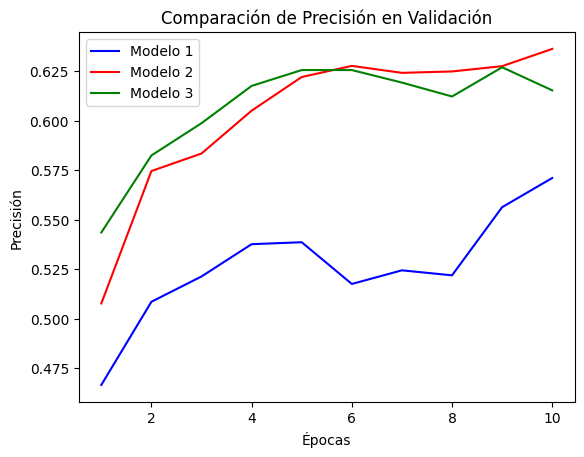

In [ ]:
# Comparar la precisión en validación de los tres modelos durante las épocas
min_epochs = min(len(accuracy_model_1), len(accuracy_model_2), len(accuracy_model_3))  # Obtener el número mínimo de épocas para comparación
epochs = range(1, min_epochs + 1)  # Crear el rango de épocas

# Graficar la precisión de validación para cada modelo
plt.plot(epochs, accuracy_model_1[:min_epochs], 'b', label='Modelo 1')  # Modelo 1 en azul
plt.plot(epochs, accuracy_model_2[:min_epochs], 'r', label='Modelo 2')  # Modelo 2 en rojo
plt.plot(epochs, accuracy_model_3[:min_epochs], 'g', label='Modelo 3')  # Modelo 3 en verde

plt.title('Comparación de Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


# Visualizar cómo los modelos aprendieron a través del Tiempo

# Modelo 1

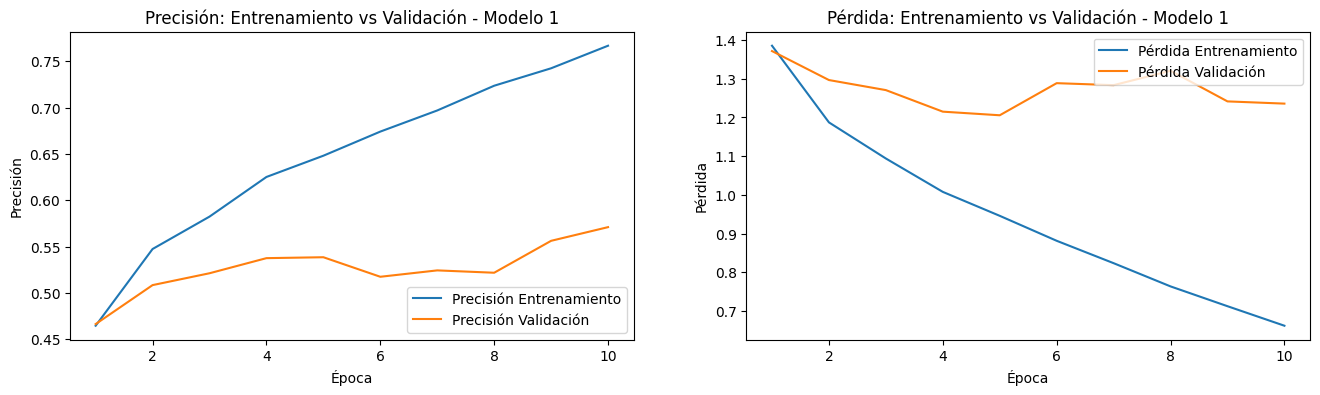

In [ ]:
# Obtener los valores de precisión y pérdida del historial de entrenamiento
train_acc = history_1.history['accuracy']       # Precisión en entrenamiento
val_acc = history_1.history['val_accuracy']     # Precisión en validación
train_loss = history_1.history['loss']          # Pérdida en entrenamiento
val_loss = history_1.history['val_loss']        # Pérdida en validación

# Definir el eje x como el número de épocas
epochs = range(1, len(train_loss) + 1)

# Crear una figura con dos gráficos (subplots) en una sola fila
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Graficar la precisión en entrenamiento y validación por época
axs[0].plot(epochs, train_acc, label='Precisión Entrenamiento')
axs[0].plot(epochs, val_acc, label='Precisión Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Precisión')
axs[0].legend(loc='lower right')
axs[0].set_title('Precisión: Entrenamiento vs Validación - Modelo 1')

# Graficar la pérdida en entrenamiento y validación por época
axs[1].plot(epochs, train_loss, label='Pérdida Entrenamiento')
axs[1].plot(epochs, val_loss, label='Pérdida Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Pérdida')
axs[1].legend(loc='upper right')
axs[1].set_title('Pérdida: Entrenamiento vs Validación - Modelo 1')

# Mostrar la figura
plt.show()



# Modelo 2

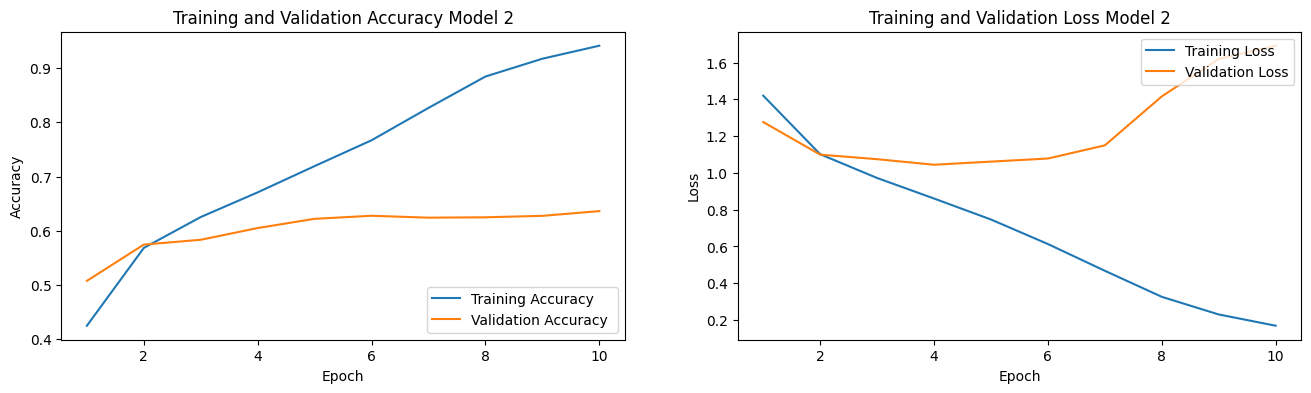

In [ ]:
# Obtener las métricas de precisión y pérdida del historial de entrenamiento del modelo 2
train_acc = history_2.history['accuracy']         # Precisión en los datos de entrenamiento por época
val_acc = history_2.history['val_accuracy']       # Precisión en los datos de validación por época
train_loss = history_2.history['loss']            # Pérdida en los datos de entrenamiento por época
val_loss = history_2.history['val_loss']          # Pérdida en los datos de validación por época

# Definir el eje x como el número de épocas (comienza en 1 hasta el número total de épocas)
epochs = range(1, len(train_loss) + 1)

# Crear una figura con dos gráficos (subplots) en una sola fila
fig, axs = plt.subplots(1, 2, figsize=(16, 4))    # figsize define el tamaño de la figura (ancho, alto)

# Graficar la precisión de entrenamiento y validación por época en el primer gráfico
axs[0].plot(epochs, train_acc, label='Training Accuracy')     # Línea para la precisión en entrenamiento
axs[0].plot(epochs, val_acc, label='Validation Accuracy ')    # Línea para la precisión en validación
axs[0].set_xlabel('Epoch')                                    # Etiqueta del eje x
axs[0].set_ylabel('Accuracy')                                 # Etiqueta del eje y
axs[0].legend(loc='lower right')                              # Colocar la leyenda en la esquina inferior derecha
axs[0].set_title('Training and Validation Accuracy Model 2')  # Título del primer gráfico

# Graficar la pérdida de entrenamiento y validación por época en el segundo gráfico
axs[1].plot(epochs, train_loss, label='Training Loss')        # Línea para la pérdida en entrenamiento
axs[1].plot(epochs, val_loss, label='Validation Loss')        # Línea para la pérdida en validación
axs[1].set_xlabel('Epoch')                                    # Etiqueta del eje x
axs[1].set_ylabel('Loss')                                     # Etiqueta del eje y
axs[1].legend(loc='upper right')                              # Colocar la leyenda en la esquina superior derecha
axs[1].set_title('Training and Validation Loss Model 2')      # Título del segundo gráfico

# Mostrar los gráficos en pantalla
plt.show()



# Modelo 3

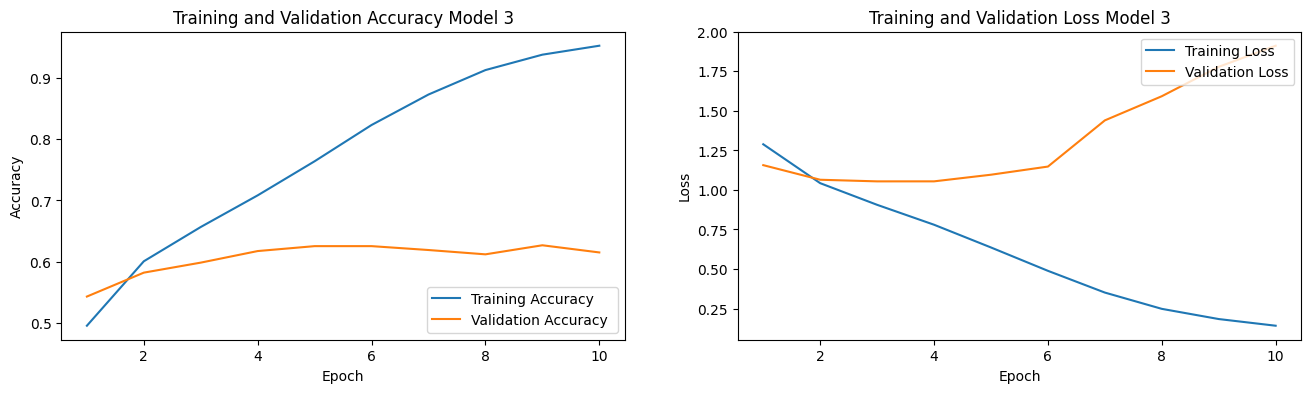

In [ ]:
# Obtener los valores de exactitud (accuracy) y pérdida (loss) del historial de entrenamiento del modelo 3
train_acc = history_3.history['accuracy']        # Exactitud en los datos de entrenamiento
val_acc = history_3.history['val_accuracy']      # Exactitud en los datos de validación
train_loss = history_3.history['loss']           # Pérdida en los datos de entrenamiento
val_loss = history_3.history['val_loss']         # Pérdida en los datos de validación

# Definir el eje X como el número de épocas
epochs = range(1, len(train_loss) + 1)           # Crear una secuencia de números desde 1 hasta el número total de épocas

# Crear una figura con dos subgráficos (subplots) lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 4))   # Crear una figura de 1 fila y 2 columnas con tamaño 16x4 pulgadas

# Graficar la exactitud de entrenamiento y validación por época
axs[0].plot(epochs, train_acc, label='Training Accuracy')      # Línea de exactitud en entrenamiento
axs[0].plot(epochs, val_acc, label='Validation Accuracy ')     # Línea de exactitud en validación
axs[0].set_xlabel('Epoch')                                     # Etiqueta del eje X
axs[0].set_ylabel('Accuracy')                                  # Etiqueta del eje Y
axs[0].legend(loc='lower right')                               # Ubicación de la leyenda
axs[0].set_title('Training and Validation Accuracy Model 3')   # Título del gráfico

# Graficar la pérdida de entrenamiento y validación por época
axs[1].plot(epochs, train_loss, label='Training Loss')         # Línea de pérdida en entrenamiento
axs[1].plot(epochs, val_loss, label='Validation Loss')         # Línea de pérdida en validación
axs[1].set_xlabel('Epoch')                                     # Etiqueta del eje X
axs[1].set_ylabel('Loss')                                      # Etiqueta del eje Y
axs[1].legend(loc='upper right')                               # Ubicación de la leyenda
axs[1].set_title('Training and Validation Loss Model 3')       # Título del gráfico

# Mostrar la figura con los gráficos
plt.show()                                                     # Visualizar los gráficos en pantalla



# Predecir Ramdom Imagenes usando el Modelo 2

In [ ]:
# Obtener los índices de las clases del generador de entrenamiento
class_indices = train_generator.class_indices

# Invertir el diccionario para mapear de índice a nombre de clase
class_names = dict((v, k) for k, v in class_indices.items())

# Mostrar el diccionario resultante con los nombres de las clases
class_names


{0: 'angry', 1: 'fearful', 2: 'happy', 3: 'neutral', 4: 'sad', 5: 'surprised'}

# Predecir emociones a partir de una imagen cargada aleatoriamente

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[7.6056982e-12 4.5530307e-03 8.6391117e-07 1.7965467e-16 1.5456718e-12
  9.9544603e-01]]
Predicted class: 5


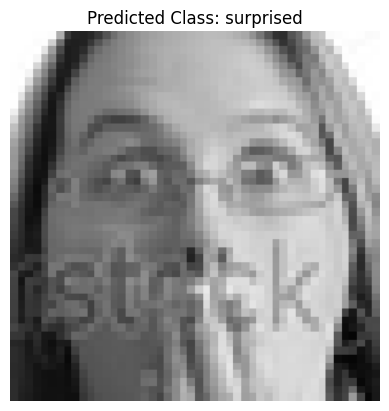

In [ ]:
# Usamos el mejor modelo y una imagen de otro dataset para predecir emociones
uploaded_image_path = '../input/emotion-detection-fer/test/surprised/im0.png'

# Cargar y preprocesar la imagen
img = image.load_img(uploaded_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Realizar la predicción con el modelo entrenado
predictions = model_2.predict(img_array)
print(predictions)

# Obtener el índice de la clase con mayor probabilidad
predicted_class_index = np.argmax(predictions)
print("Predicted class:", predicted_class_index)

# Obtener el nombre de la clase correspondiente
predicted_class_name = class_names[predicted_class_index]

# Mostrar la imagen con la clase predicha como título
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.9971642e-08 3.2669686e-06 9.6230167e-01 1.4948176e-04 4.2530019e-06
  3.7541218e-02]]
Predicted class: 2


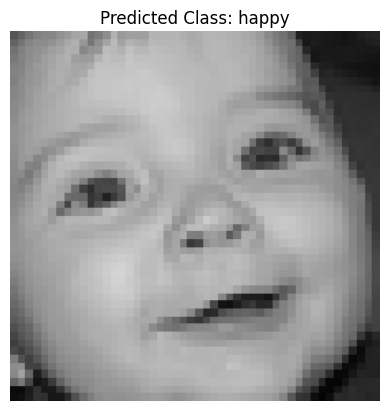

In [ ]:
# Usamos el mejor modelo y una imagen de otro dataset para predecir emociones
uploaded_image_path = '../input/emotion-detection-fer/test/happy/im1005.png'

# Cargar y preprocesar la imagen
img = image.load_img(uploaded_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Realizar la predicción con el modelo entrenado
predictions = model_2.predict(img_array)
print(predictions)

# Obtener el índice de la clase con mayor probabilidad
predicted_class_index = np.argmax(predictions)
print("Predicted class:", predicted_class_index)

# Obtener el nombre de la clase correspondiente
predicted_class_name = class_names[predicted_class_index]

# Mostrar la imagen con la clase predicha como título
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.06755749e-06 6.50253287e-03 1.08822394e-04 4.50236320e-01
  3.65256652e-04 5.42786002e-01]]
Predicted class: 5


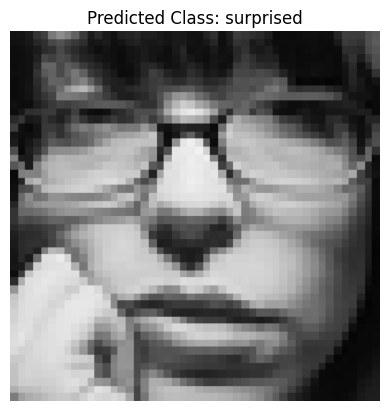

In [ ]:
# Usamos el mejor modelo y una imagen de otro dataset para predecir emociones
uploaded_image_path = '../input/emotion-detection-fer/test/neutral/im1001.png'

# Cargar y preprocesar la imagen
img = image.load_img(uploaded_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Realizar la predicción con el modelo entrenado
predictions = model_2.predict(img_array)
print(predictions)

# Obtener el índice de la clase con mayor probabilidad
predicted_class_index = np.argmax(predictions)
print("Predicted class:", predicted_class_index)

# Obtener el nombre de la clase correspondiente
predicted_class_name = class_names[predicted_class_index]

# Mostrar la imagen con la clase predicha como título
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[7.4396133e-02 1.2490376e-01 3.5878715e-01 3.6137677e-09 9.1199181e-05
  4.4182169e-01]]
Predicted class: 5


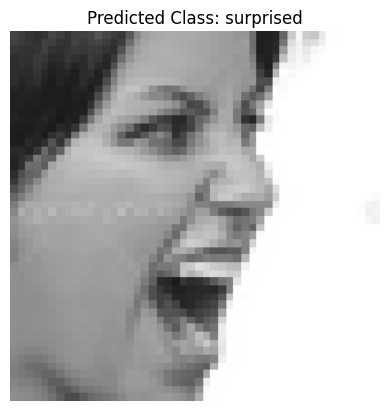

In [ ]:
# Usamos el mejor modelo y una imagen de otro dataset para predecir emociones
uploaded_image_path = '../input/emotion-detection-fer/test/fearful/im1008.png'

# Cargar y preprocesar la imagen
img = image.load_img(uploaded_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Realizar la predicción con el modelo entrenado
predictions = model_2.predict(img_array)
print(predictions)

# Obtener el índice de la clase con mayor probabilidad
predicted_class_index = np.argmax(predictions)
print("Predicted class:", predicted_class_index)

# Obtener el nombre de la clase correspondiente
predicted_class_name = class_names[predicted_class_index]

# Mostrar la imagen con la clase predicha como título
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()

# Predecir emociones usando un subconjunto de prueba de otro conjunto de datos

In [ ]:
# Directorio de test
test_dir = '../input/emotion-detection-fer/test/'

# Preprocesamiento para los datos de test
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador para el conjunto de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7178 images belonging to 7 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


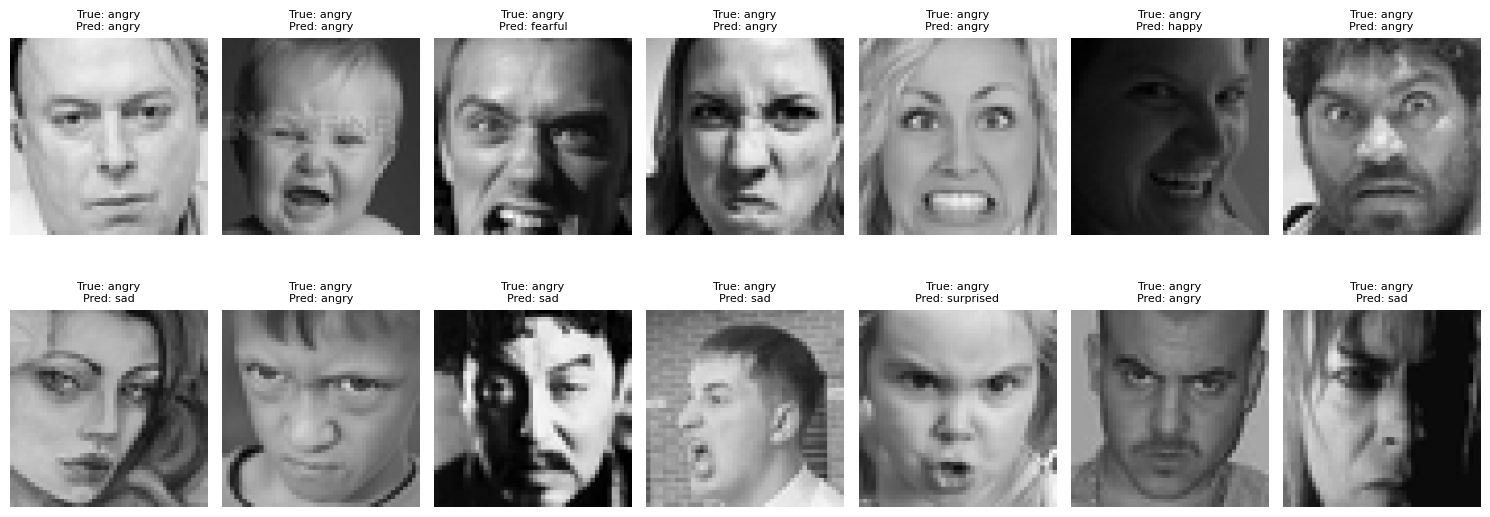

In [ ]:
# Tomamos un lote del generador de prueba
test_images = test_generator[0][0]
test_labels = test_generator[0][1]

# Realizamos predicciones con el modelo
predicted_labels = model_2.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Etiquetas de clase (ordenadas según class_indices)
class_labels = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Número de imágenes a visualizar
num_images = 14
random_indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Creamos la figura para mostrar las imágenes
fig, axes = plt.subplots(2, 7, figsize=(15, 6))

for i, index in enumerate(random_indices):
    img = test_images[index]
    true_label = class_labels[np.argmax(test_labels[index])]
    predicted_label = class_labels[predicted_classes[index]]

    row = i // 7
    col = i % 7

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'True: {true_label}\nPred: {predicted_label}', fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# Guardar los Modelos Entrenados

In [ ]:
# Guardar el modelo completo (arquitectura, pesos y configuración de entrenamiento) en formato HDF5 (.h5)
# Esto permite reutilizar el modelo más adelante sin necesidad de reentrenarlo
model_1.save('path_to_my_model_1.h5')
model_2.save('path_to_my_model_2.h5')
model_3.save('path_to_my_model_3.h5')


In [ ]:
# Importar la biblioteca Keras y mostrar su versión actual instalada
import keras
print(keras.__version__)


3.0.5
